# Regularization of ANN weights


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

Load the [Auto MPG dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg).


In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]
data = pd.read_csv(
    url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)
data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


Check is there are missing entries in the dataset.


In [3]:
print(data.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


Remove records with missing entries.


In [4]:
data = data.dropna()
print(data.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


## Data inspection

Display some basic information.


In [5]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [7]:
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


We are interested in predicting the field `MPG`, measuring [fuel efficiency](https://en.wikipedia.org/wiki/Fuel_efficiency#:~:text=Fuel%20economy%20is%20the%20distance,a%20certain%20volume%20of%20fuel)), expressed in miles per gallon (MPG), where 1 MPG = 0.354006 km/L. Plot its distribution.


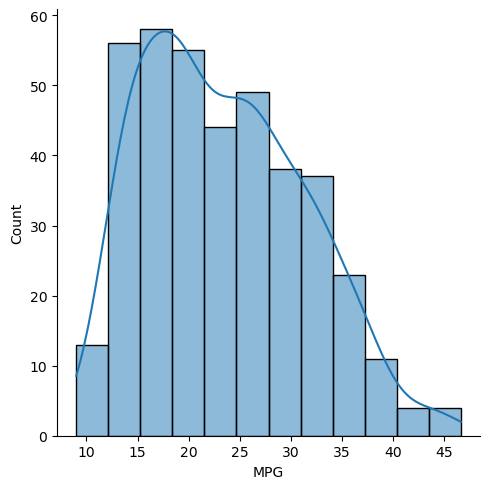

In [8]:
sns.displot(data["MPG"], kde=True)

Look for linear correlations among data.


In [9]:
data.corr()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
MPG,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
Cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
Displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
Horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
Weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
Acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
Model Year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
Origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


<Axes: >

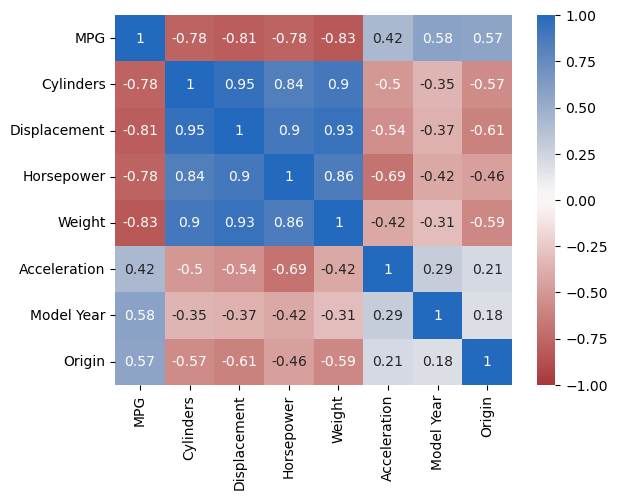

In [10]:
sns.heatmap(data.corr(), annot=True, cmap="vlag_r", vmin=-1, vmax=1)

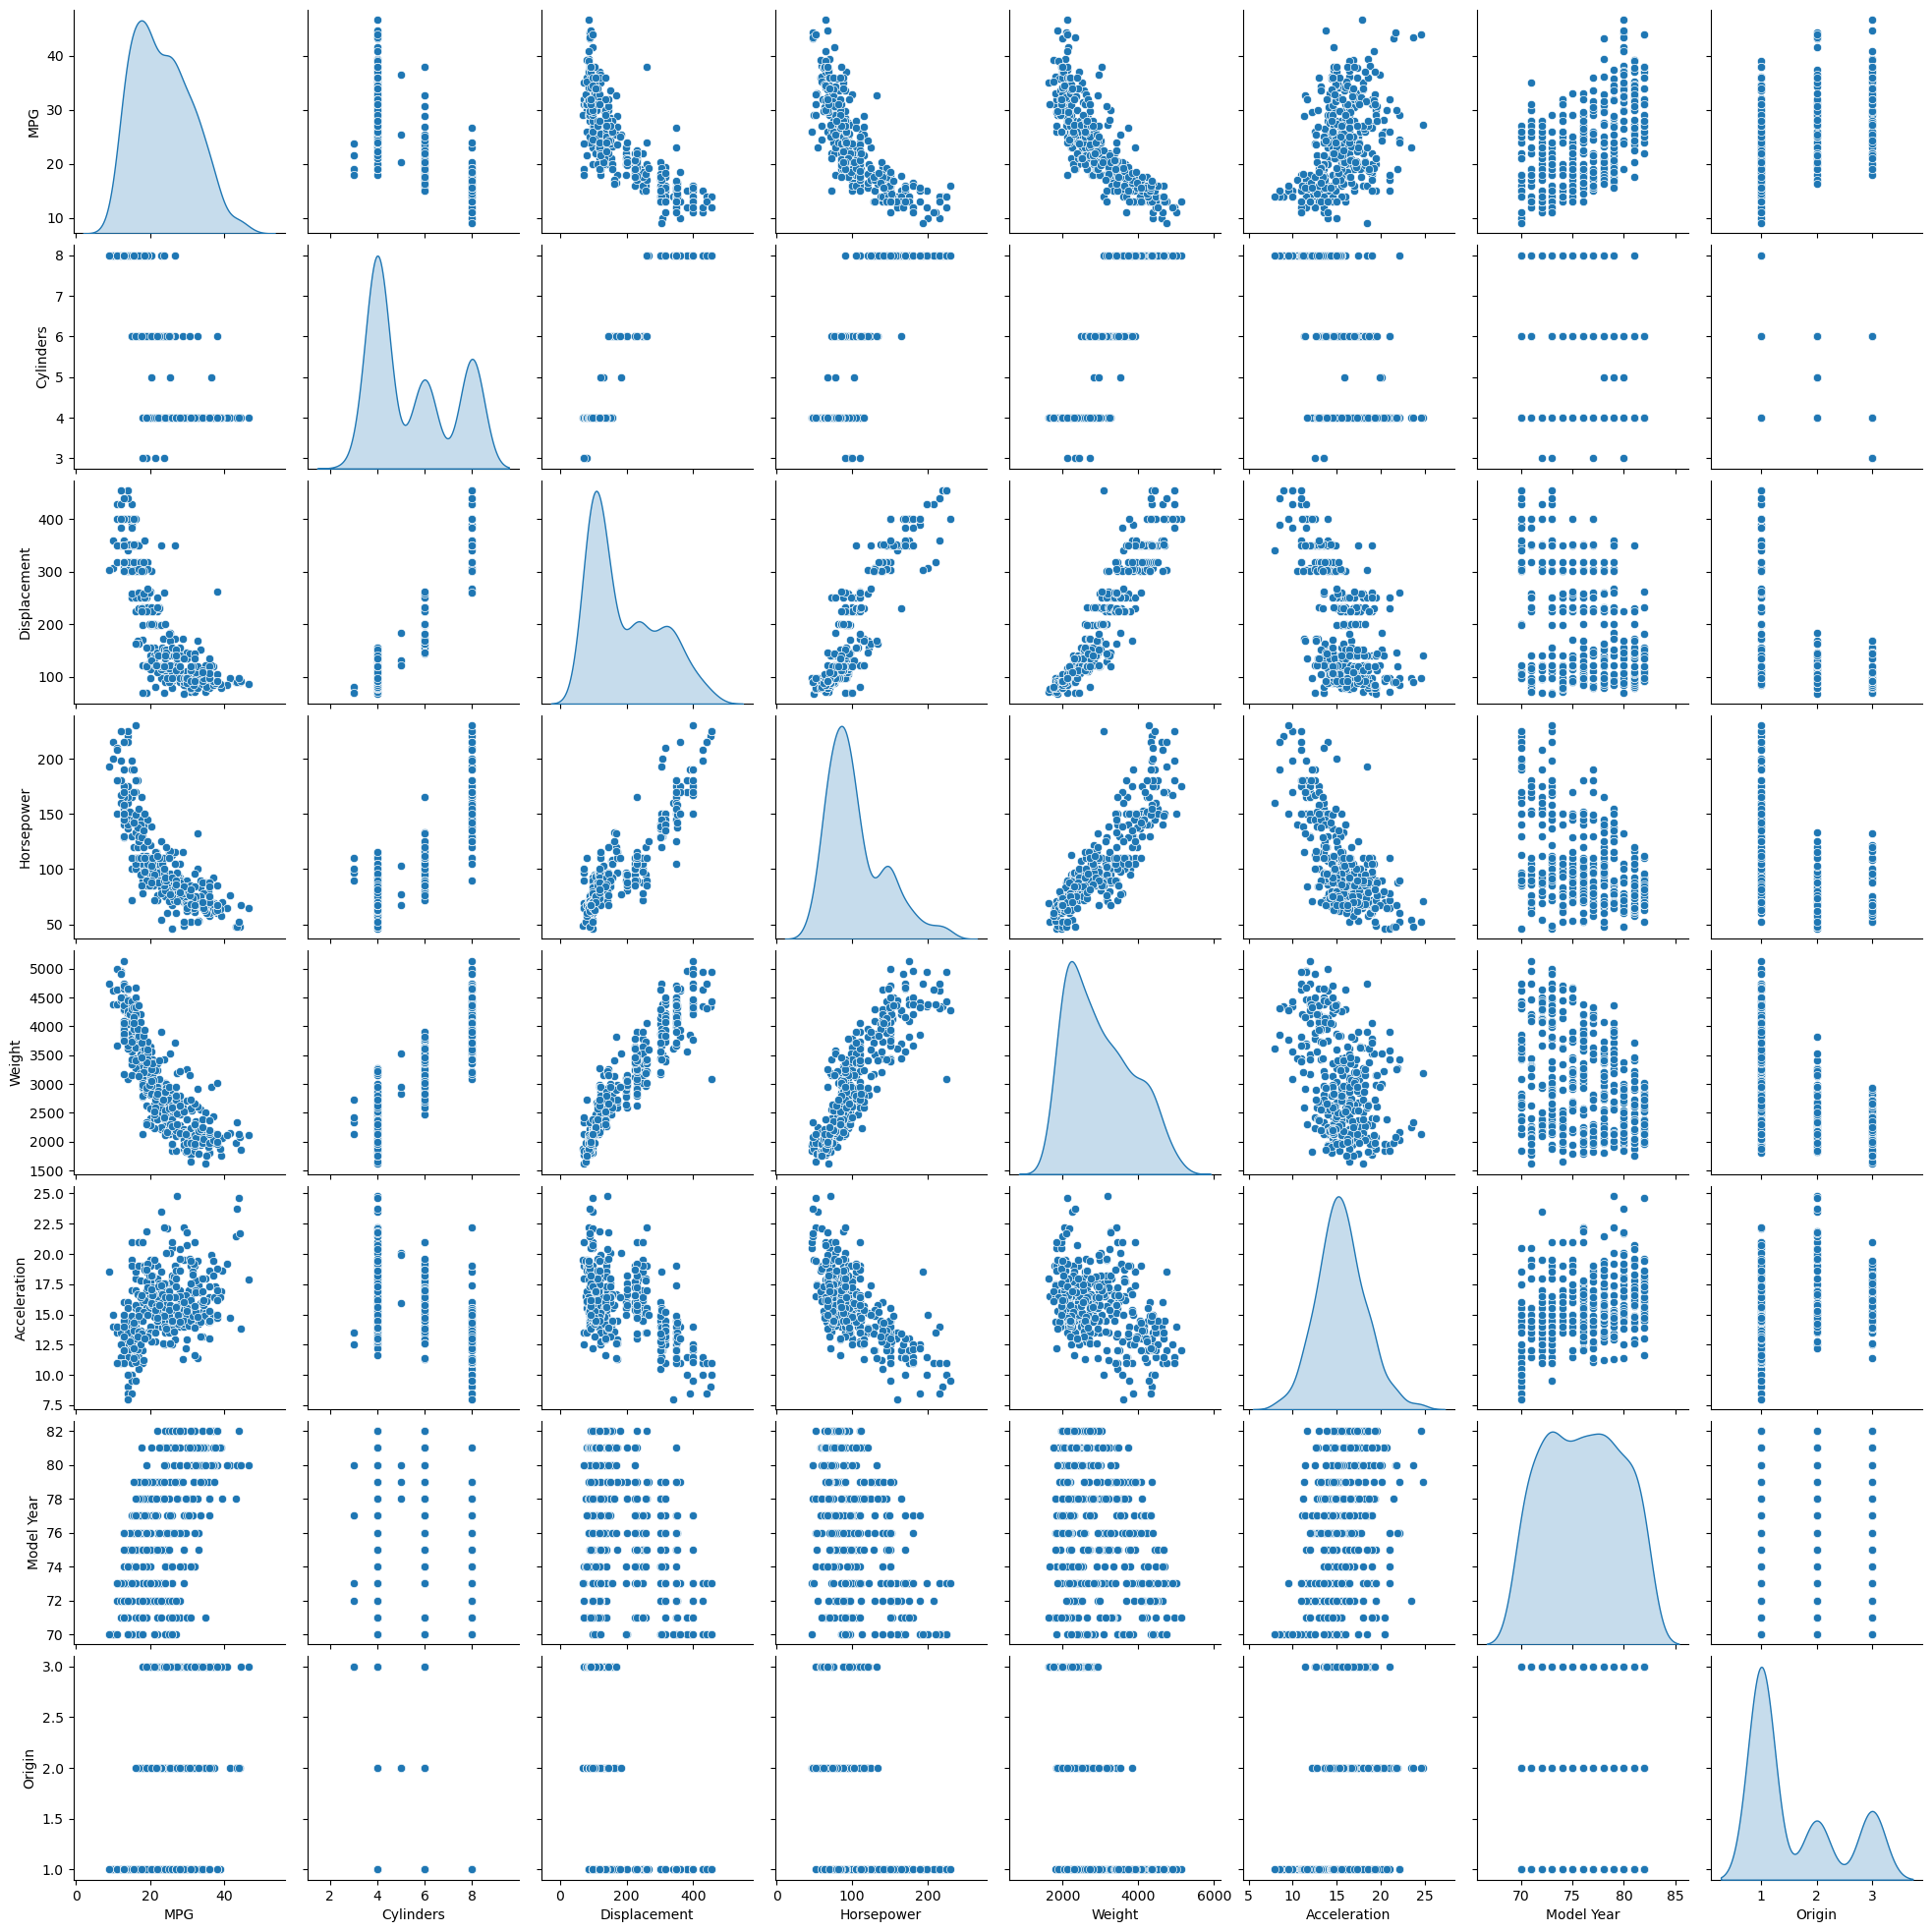

In [11]:
sns.pairplot(data, diag_kind="kde")

## Data normalization

Apply an affine transformation to the data, so that each feature has zero mean and unitary standard deviation.


In [12]:
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

<Axes: >

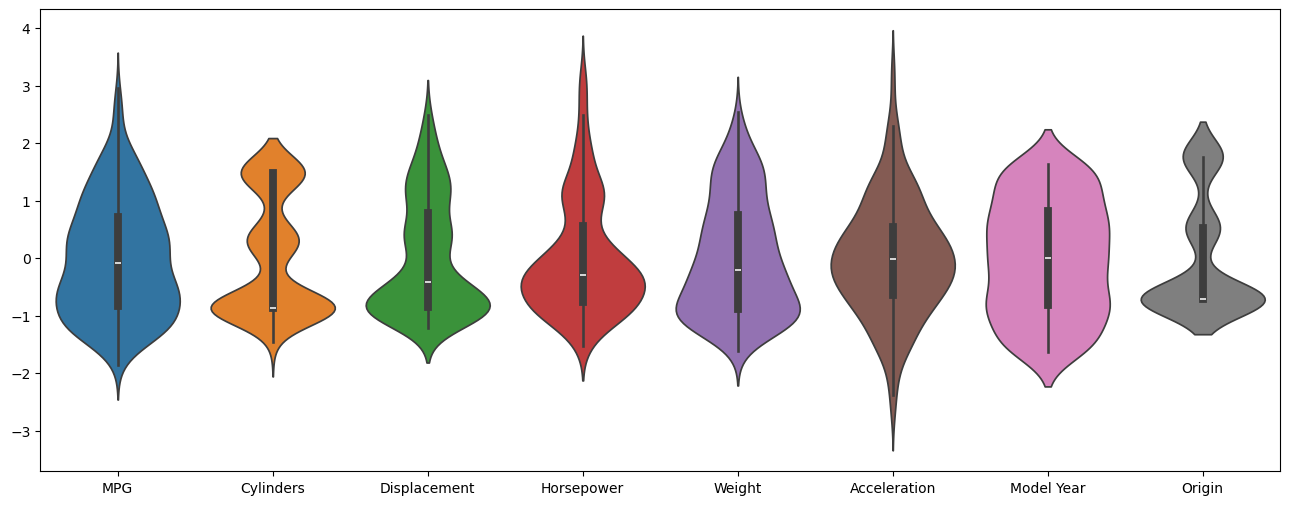

In [13]:
_, ax = plt.subplots(figsize=(16, 6))
sns.violinplot(data=data_normalized, ax=ax)

## Train-validation split

Shuffle the data using the [np.random.shuffle](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html) function and split the data as follows:

- put 80% in the train dataset
- put 20% in the validation dataset


In [14]:
data_normalized_np = data_normalized.to_numpy()
np.random.seed(0)
np.random.shuffle(data_normalized_np)

fraction_validation = 0.2
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))
x_train = data_normalized_np[:num_train, 1:]
y_train = data_normalized_np[:num_train, :1]
x_valid = data_normalized_np[num_train:, 1:]
y_valid = data_normalized_np[num_train:, :1]

print("train set size     : %d" % x_train.shape[0])
print("validation set size: %d" % x_valid.shape[0])

train set size     : 313
validation set size: 79


## ANN setup

Write a function `params = initialize_params(layers_size)` that initializes the parameters, given the ANN architecture.
Initialize biases with zero values, and weights with a [Glorot Normal](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization, i.e. sampling from a Gaussian distribution with zero mean and with standard deviation

$$
\sqrt{\frac{2}{n + m}},
$$

where $n$ and $m$ are the number of input and output neurons of the corresponding weights matrix.


In [15]:
def initialize_params(layers_size):
    np.random.seed(0)  # for reproducibility
    params = list()
    for i in range(len(layers_size) - 1):
        W = np.random.randn(layers_size[i + 1], layers_size[i]) * np.sqrt(
            2 / (layers_size[i + 1] + layers_size[i])
        )
        b = np.zeros((layers_size[i + 1], 1))
        params.append(W)
        params.append(b)
    return params

Implement a generic feedforward ANN with a function `y = ANN(x, params)`, using $ReLU$ as activation function.


In [16]:
activation = jax.nn.relu


def ANN(x, params):
    layer = x.T
    num_layers = int(len(params) / 2 + 1)
    weights = params[0::2]
    biases = params[1::2]
    for i in range(num_layers - 1):
        layer = weights[i] @ layer - biases[i]
        if i < num_layers - 2:
            layer = activation(layer)
    return layer.T


params = initialize_params([7, 10, 1])
ANN(x_train[:10, :], params)

Array([[-0.27655408],
       [-0.15536341],
       [ 0.48314786],
       [-0.56939894],
       [-0.00754281],
       [ 0.01332847],
       [ 0.02310115],
       [ 0.27127817],
       [ 0.35476035],
       [ 0.08180778]], dtype=float32)

Implement the quadratic loss (MSE) function `L = MSE(x, y, params)`.


In [17]:
def MSE(x, y, params):
    error = ANN(x, params) - y
    return jnp.mean(error * error)


params = initialize_params([7, 10, 1])
print(MSE(x_train, y_train, params))

1.3815352


Implement an $l^2$ regularization term for the ANN weights:

$$
\mathrm{MSW} = \frac{1}{n_{weights}} \sum_{i=1}^{n_{weights}} w_i^2
$$

and define the loss function as

$$
\mathcal{L} = \mathrm{MSE} + \beta \, \mathrm{MSW}
$$

where $\beta$ is a suitable penalization parameter.


In [18]:
def MSW(params):
    weights = params[::2]
    partial_sum = 0.0
    n_weights = 0
    for W in weights:
        partial_sum += jnp.sum(W * W)
        n_weights += W.shape[0] * W.shape[1]
    return partial_sum / n_weights


def loss(x, y, params, penalization):
    return MSE(x, y, params) + penalization * MSW(params)


print(MSW(params))
print(loss(x_train, y_train, params, 1.0))

0.1233696
1.5049047


Run this cell: we will this callback to monitor training.


In [19]:
from IPython import display


class Callback:
    def __init__(self, refresh_rate=250):
        self.refresh_rate = refresh_rate
        self.fig, self.axs = plt.subplots(1, figsize=(16, 8))
        self.epoch = 0
        self.__call__(-1)

    def __call__(self, epoch):
        self.epoch = epoch
        if (epoch + 1) % self.refresh_rate == 0:
            self.draw()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-16)

    def draw(self):
        if self.epoch > 0:
            self.axs.clear()
            self.axs.loglog(history_loss_train, "b-", label="loss train")
            self.axs.loglog(history_loss_valid, "r-", label="loss validation")
            self.axs.loglog(history_MSE_train, "b--", label="RMSE train")
            self.axs.loglog(history_MSE_valid, "r--", label="RMSE validation")
            self.axs.legend()
            self.axs.set_title("epoch %d" % (self.epoch + 1))

## Training

Train an ANN with two hidden layers with 20 neurons each, using 5000 epochs of the SGD method (with minibatch size 100) with momentum ($\alpha = 0.9$).
Employ a linear decay of the learning rate:

$$
\lambda_k = \max\left(\lambda_{\textnormal{min}}, \lambda_{\textnormal{max}} \left(1 - \frac{k}{K}\right)\right)
$$

with $\lambda_{\textnormal{min}} = 5e-3$, $\lambda_{\textnormal{max}} = 1e-1$ and decay length $K= 1000$.

During training, store both the MSE error and the loss function obtained on the train and validation sets in 4 lists, respectively called:

- `history_loss_train`
- `history_loss_valid`
- `history_MSE_train`
- `history_MSE_valid`

Test different choices of the penalization parameter $\beta$.


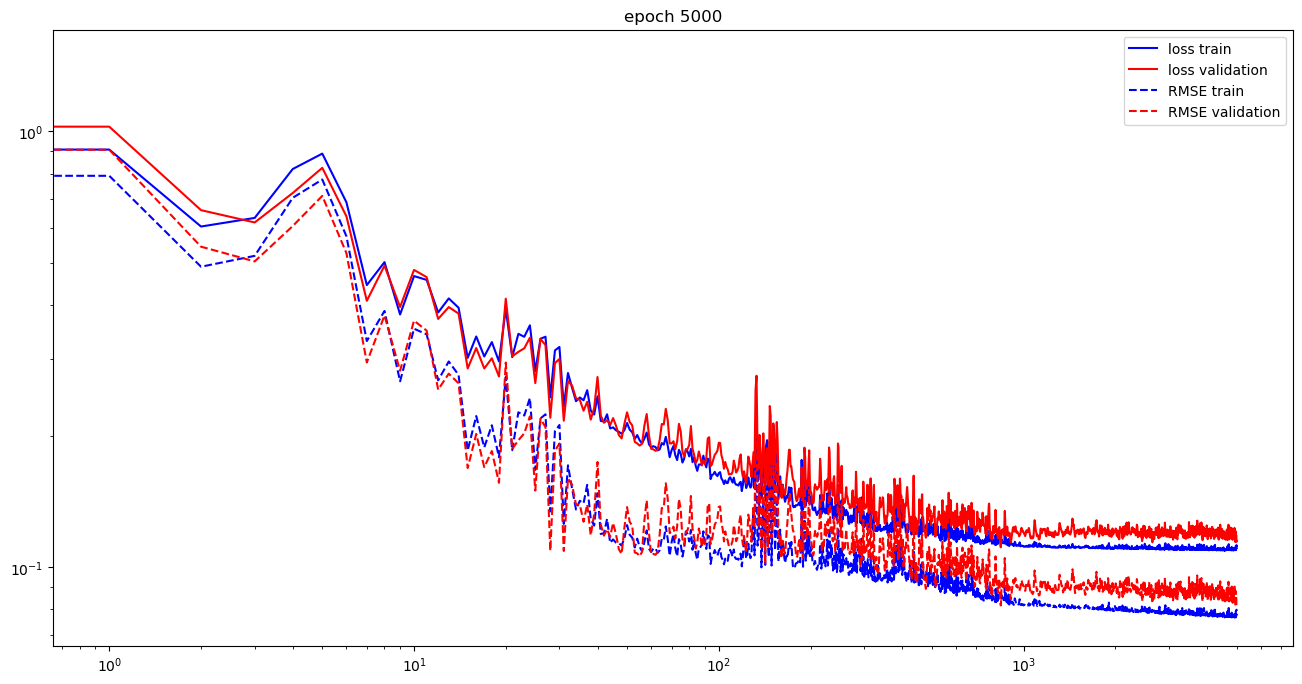

loss (train     ): 1.118e-01
loss (validation): 1.149e-01
MSE  (train     ): 7.932e-02
MSE  (validation): 8.244e-02


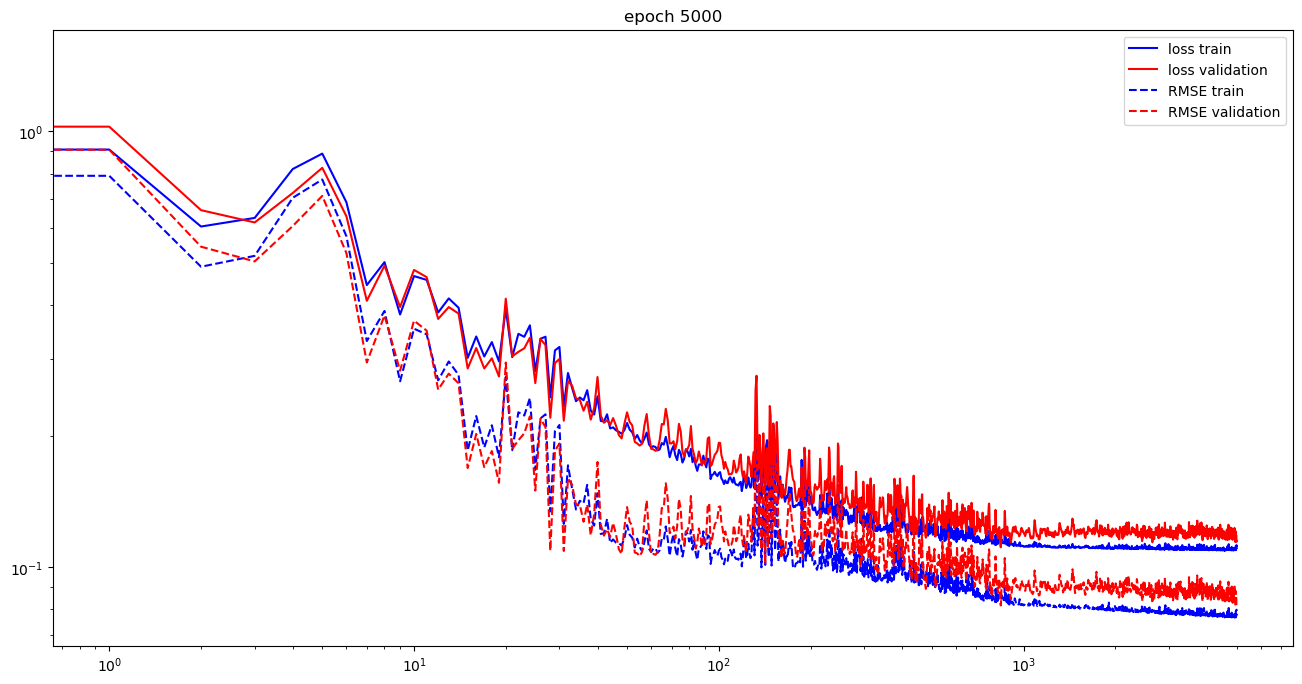

In [20]:
# Hyperparameters
layers_size = [7, 20, 20, 1]
penalization = 2.0
# Training options
num_epochs = 5000
learning_rate_max = 1e-1
learning_rate_min = 5e-3
learning_rate_decay = 1000
batch_size = 100
alpha = 0.9
########################################

params = initialize_params(layers_size)

grad = jax.grad(loss, argnums=2)
MSE_jit = jax.jit(MSE)
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

n_samples = x_train.shape[0]

history_loss_train = list()
history_loss_valid = list()
history_MSE_train = list()
history_MSE_valid = list()


def dump():
    history_loss_train.append(loss_jit(x_train, y_train, params, penalization))
    history_loss_valid.append(loss_jit(x_valid, y_valid, params, penalization))
    history_MSE_train.append(MSE_jit(x_train, y_train, params))
    history_MSE_valid.append(MSE_jit(x_valid, y_valid, params))


dump()
cb = Callback(refresh_rate=500)

velocity = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
    learning_rate = max(
        learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
    )
    idxs = np.random.choice(n_samples, batch_size)
    grads = grad_jit(x_train[idxs, :], y_train[idxs, :], params, penalization)

    for i in range(len(params)):
        velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
        params[i] += velocity[i]

    dump()
    cb(epoch)
cb.draw()

print("loss (train     ): %1.3e" % history_loss_train[-1])
print("loss (validation): %1.3e" % history_loss_valid[-1])
print("MSE  (train     ): %1.3e" % history_MSE_train[-1])
print("MSE  (validation): %1.3e" % history_MSE_valid[-1])

We now want to to investigate more in depth the effect of the penalization parameter $\beta$.
Write a function that, given the penalization parameter, trains the ANN (with the same setting used above) and returns a dictionary containing the final values of:

- train MSE
- validation MSE
- MSW


In [21]:
# Hyperparameters
layers_size = [7, 20, 20, 1]
# Training options
num_epochs = 5000
learning_rate_max = 1e-1
learning_rate_min = 5e-3
learning_rate_decay = 1000
batch_size = 100
alpha = 0.9


def train(penalization):

    params = initialize_params(layers_size)
    n_samples = x_train.shape[0]

    velocity = [0.0 for i in range(len(params))]
    for epoch in range(num_epochs):
        learning_rate = max(
            learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
        )
        idxs = np.random.choice(n_samples, batch_size)
        grads = grad_jit(x_train[idxs, :], y_train[idxs, :], params, penalization)
        for i in range(len(params)):
            velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
            params[i] += velocity[i]
    return {
        "MSE_train": MSE(x_train, y_train, params),
        "MSE_valid": MSE(x_valid, y_valid, params),
        "MSW": MSW(params),
    }

Using the above defined function, store the obtained results for $\beta = 0, 0.25, 0.5, 0.75, \dots, 2$.


In [22]:
results = {
    "MSE_train": list(),
    "MSE_valid": list(),
    "MSW": list(),
}

pen_values = np.arange(0, 2.1, 0.5)
for p in pen_values:
    print("training for p = %f..." % p)
    res = train(p)
    results["MSE_train"].append(res["MSE_train"])
    results["MSE_valid"].append(res["MSE_valid"])
    results["MSW"].append(res["MSW"])

training for p = 0.000000...
training for p = 0.500000...
training for p = 1.000000...
training for p = 1.500000...
training for p = 2.000000...


Plot the trend of the five quantities as functions of $\beta$.


Text(0.5, 1.0, 'MSW')

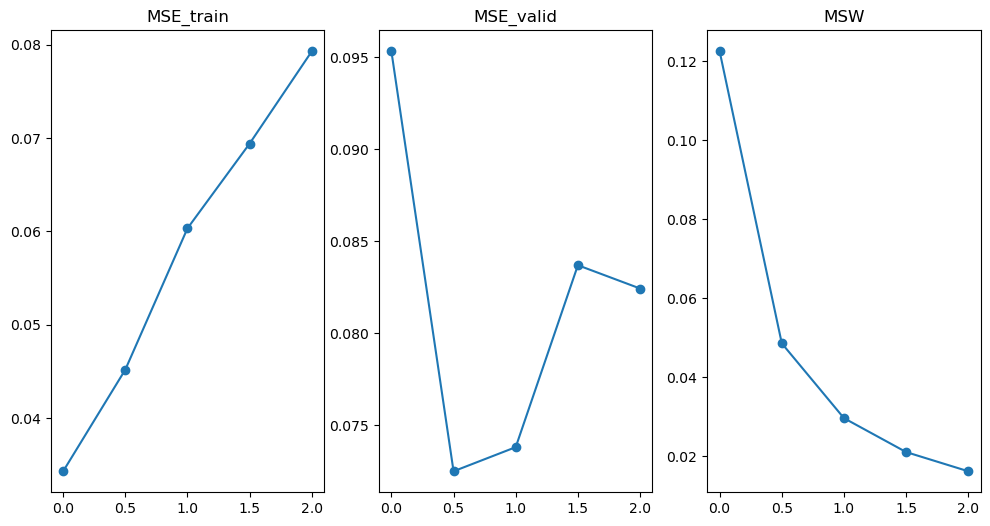

In [23]:
_, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].plot(pen_values, results["MSE_train"], "o-")
axs[1].plot(pen_values, results["MSE_valid"], "o-")
axs[2].plot(pen_values, results["MSW"], "o-")

axs[0].set_title("MSE_train")
axs[1].set_title("MSE_valid")
axs[2].set_title("MSW")

Plot the _Tikhonov L-curve_, which is - in this context - the curve "train MSE" versus "MSW".


Text(0, 0.5, 'MSE_train')

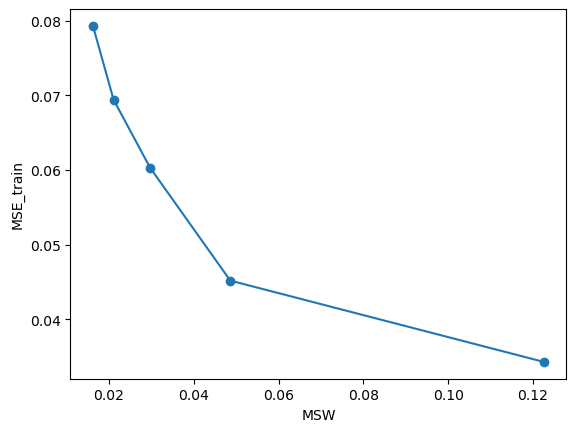

In [24]:
plt.plot(results["MSW"], results["MSE_train"], "o-")
plt.xlabel("MSW")
plt.ylabel("MSE_train")